# LRG Position Matching

We need a sample of LRGs that span the range of redshifts and i-band magnitudes found in the OM10 catalog. The sample can be kept small by selecting in color as well as magnitude and redshift. CFHTLS is our first choice, given the depth of the OM10 catalog - but a good LRG pre-selection is not available. In this notebook we explore the CFHTLS option, and then try SDSS instead.

In [1]:
%matplotlib inline
import om10,os
import numpy as np
import matplotlib.pyplot as plt
import triangle

## 1. The Existing CFHTLS LRGs

First, let's plot the old CFHTLS catalog, and overlay the OM10 lens galaxies. We can paint the latter with SDSS colors, to see how they compare.

In [2]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

In [3]:
data = np.loadtxt(os.path.expandvars("$OM10_DIR/data/CFHTLS_LRGs.txt"))

### 1.1 Magnitude vs Redshift

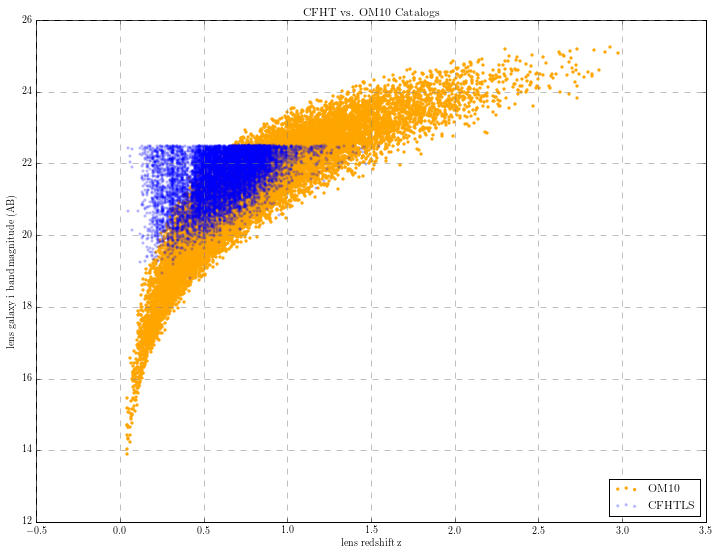

In [4]:
fig = plt.figure()
fig.set_size_inches(12,9)
plt.scatter(db.lenses['ZLENS'],db.lenses['APMAG_I'],color='Orange',marker='.',label='OM10',alpha=1)
plt.scatter(data[:,2],data[:,6],color='Blue',marker='.',label='CFHTLS',alpha=0.2)
plt.title('CFHT vs. OM10 Catalogs')
plt.xlabel('lens redshift z')
plt.ylabel('lens galaxy i band magnitude (AB)')
plt.legend(loc=4)
plt.grid(color='grey', linestyle='--', linewidth=0.5)

This is an attempt at a more restrictive initial selection, to efficiently focus on the brightest galaxies at each redshift bin. The next thing is to try and focus the sample even more, on the red sequence.

### 1.2 Color-Color-Magnitude-Redshift Triangle Plot 

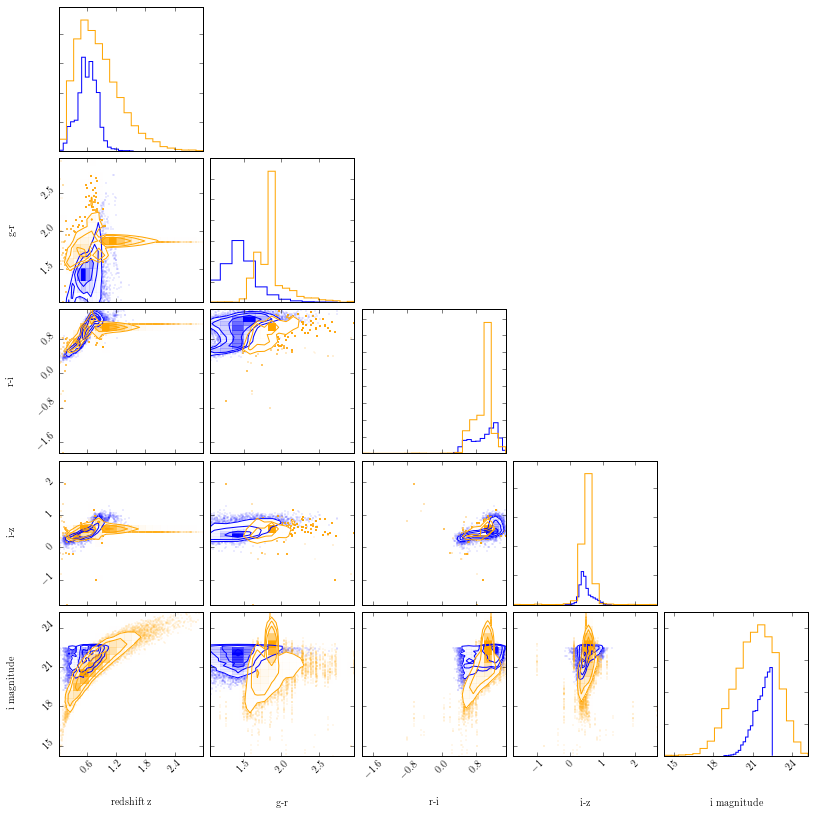

In [5]:
# Make CFHTLS colors:
gr = data[:,4] - data[:,5]
ri = data[:,5] - data[:,6]
iz = data[:,6] - data[:,7]
i = data[:,6]
z = data[:,2]

# Clean out extreme CFHTLS values:
index = np.where((np.abs(gr)<3.0)*(np.abs(ri)<3.0)*(np.abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Now arrange the painted OM10 lenses, again cleaning out extreme values:
OMgr = db.sample['MAGG_LENS']-db.sample['MAGR_LENS']
OMri = db.sample['MAGR_LENS']-db.sample['MAGI_LENS']
OMiz = db.sample['MAGI_LENS']-db.sample['MAGZ_LENS']
OMi = db.sample['MAGI_LENS']
OMz = db.sample['ZLENS']
index = np.where((np.abs(OMgr)<3.0)*(np.abs(OMri)<3.0)*(np.abs(OMiz)<3.0))

overlay = np.array([OMz[index], \
                    OMgr[index], \
                    OMri[index], \
                    OMiz[index], \
                    OMi[index]]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)


Look at the g-r vs. redshift panel: as we go to higher redshift, these galaxies are getting redder as required - that's good. However, the CFHTLS LRGs seem to be systematically bluer in g-r color, and we run out of objects at faint magnitudes - and at high redshifts in a given magnitude bin. We need a good way of selecting old, massive galaxies at redshifts above 1: selecting magnitude-limited samples will just get us a lot of blue, star-forming galaxies. 

When position-matching, we really need to select objects that could plausibly act as lenses, and then paste lensed images on top of them. In the absence of an actual LRG catalog, we are stuck downloading CFHTLS objects and then making color cuts. So, maybe the best thing to do is to *first* paint colors onto the CFHTLS lenses, using the SDSS LRG colors (and some extrapolation to higher z), and *then* find an object with the right colors from the CFHTLS galaxy catalog. Knowing the colors to look for will also help improve the initial download of CFHTLS galaxies - maybe we can restrict ourselves to red galaxies sooner?

## 2. Downloading New CFHTLS Galaxies

Let's try to download a new, fainter CFHTLS_LRGs.txt catalog. Let's do this in pieces, to avoid being overloaded with useless blue galaxies. First we put all the downloading code in a `def`, and then run it multiple times with hand-crafted redshift ranges. We'll download CFHTLS galaxies in narrow i-band magnitude bins, and put a constraint on `(g-r)` at the same time. We can use the target OM10 catalog to automatically set the redshift and color selection constraints.

In [8]:
def download_CFHTLS_LRG_catalog(L,N=100000):
    
    i = L['MAGI_LENS']
    z = L['ZLENS']
    r = L['MAGR_LENS']
    g = L['MAGG_LENS']
    # c = L['MAGG_LENS'] - L['MAGR_LENS'] 
    
    # Set up magnitude bins:
    imin,imax = np.min(i),np.max(i)
    Nbins = 20
    Nperbin = int(N/(Nbins*1.0))
    ibins = np.linspace(imin,imax,Nbins+1)
    
    # List of filenames to be downloaded:
    filenames = []
    
    # Loop over bins, downloading sub-catalogs:
    for k in np.arange(Nbins):
        
        imin,imax = ibins[k],ibins[k+1]
        
        # Sensible filename:
        filename = "CFHTLS_LRGs.v2_{:.1f}-i-{:.1f}.txt".format(imin,imax) 
        output = os.path.expandvars("$OM10_DIR/data/"+filename)
    
        # Get mag and color limits - sigma clip to avoid outliers:
        index = np.where((i > imin)*(i < imax))
        nsigma = 2.0
        # Select this range of redshifts:
        zmean,zstd = np.mean(z[index]), np.std(z[index])
        zmin,zmax = zmean-nsigma*zstd, zmean+nsigma*zstd
        # Select this range of r-band magnitudes:
        rmean,rstd = np.mean(r[index]), np.std(r[index])
        rmin,rmax = rmean-nsigma*rstd, rmean+nsigma*rstd
        # Select this range of g-band magnitudes:
        gmean,gstd = np.mean(g[index]), np.std(g[index])
        gmin,gmax = gmean-nsigma*gstd, gmean+nsigma*gstd
        
        # Translate (g-r) color into g band mag:
        # gmin = cmin + rmin
        # gmax = cmax + rmax
        
        print "Querying for LRGs with g, r, i, z in the ranges",[round(gmin,1),round(gmax,1)], \
                                  [round(rmin,1), round(rmax,1)], [round(imin,1),round(imax,1)], [round(zmin,2),round(zmax,2)]
        
        # Assemble the URL:
        url = "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLens/cgi/queryt.pl?"
        url = url+"REQUEST=doQuery&LANG=ADQL&method=sync&format=ascii&query=SELECT%0D%0Atop+"+str(Nperbin)
        url = url+"%0D%0AALPHA_J2000%2C+DELTA_J2000%2C+FLUX_RADIUS%2C+CLASS_STAR%2C+fitclass%2C+Z_B%2C+Z_B_MIN%2C+Z_B_MAX%2C+T_B%2C+star_flag%2C+MAG_u%2C+MAG_g%2C+MAG_r%2C+MAG_i%2C+MAG_y%2C+MAG_z%0D%0A"
        url = url+"FROM%0D%0Acfht.clens%0D%0AWHERE%0D%0Afitclass%3E%3D0%0D%0AAND+fitclass%3C%3D0%0D%0AAND+star_flag%3C%3D0.1%0D%0A"
        url = url+"AND+MAG_i%3E%3D"+str(imin)+"%0D%0AAND+MAG_i%3C%3D"+str(imax)+"%0D%0A"
        url = url+"AND+MAG_r%3E%3D"+str(rmin)+"%0D%0AAND+MAG_r%3C%3D"+str(rmax)+"%0D%0A"
        url = url+"AND+MAG_g%3E%3D"+str(gmin)+"%0D%0AAND+MAG_g%3C%3D"+str(gmax)+"%0D%0A"
        url = url+"AND+Z_B%3E%3D"+str(zmin)+"%0D%0AAND+Z_B%3C%3D"+str(zmax)+"%0D%0A"

        # The data don't always download, so we to need try any failed searches again... 
        # Such failures are purportedly due to an error on the server side. 

        success = None
        while success is None:
            # Download the data with wget:
            !wget -q -O "$output" "$url"
            # Comment out the first line:
            !sed s/'ALPHA'/'# ALPHA'/g "$output" > junk
            !mv junk "$output"
            # Check file for download errors (this happens a lot):
            if 'Error' in open(output).read():
                print "Error downloading data, removing file "+output+" and trying again..."
                !rm $output
                success = None
            else:
                # print "    Successfully downloaded "+str(Nperbin)+" LRGs to file "+output
                !wc -l $output
                break
        
        # Add this file to the list:
        filenames.append(output)
        
    # We should now have all our files downloaded! Concatenate them into one:
    
    input = ' '.join(filenames)
    output = os.path.expandvars("$OM10_DIR/data/CFHTLS_LRGs.v2.txt")
    !echo "#  RA   Dec   redshift   u    g   r   i   z" > $output
    !cat $input | grep -v '#' | awk '{print $1,$2,$6,$11,$12,$13,$14,$16}' >> $output
    !wc -l $output

    return output

We'll need an OM10 catalog to pass to the download script, to tell it what to get.

In [9]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

In [ ]:
LRGcatalog = download_CFHTLS_LRG_catalog(db.sample)

Querying for LRGs with g, r, i, z in the ranges [10.6, 20.6] [8.0, 18.2] [13.9, 14.5] [0.04, 0.07]
       1 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs.v2.13.9-i-14.5.txt
Querying for LRGs with g, r, i, z in the ranges [12.1, 23.7] [10.4, 19.0] [14.5, 15.0] [0.04, 0.08]
       1 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs.v2.14.5-i-15.0.txt
Querying for LRGs with g, r, i, z in the ranges [13.0, 25.0] [12.0, 18.3] [15.0, 15.6] [0.04, 0.11]
       1 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs.v2.15.0-i-15.6.txt
Querying for LRGs with g, r, i, z in the ranges [13.6, 26.5] [13.1, 18.8] [15.6, 16.2] [0.07, 0.14]
       1 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs.v2.15.6-i-16.2.txt
Querying for LRGs with g, r, i, z in the ranges [14.6, 26.6] [13.7, 19.2] [16.2, 16.7] [0.07, 0.18]
       1 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs.v2.16.2-i-16.7.txt
Querying for LRGs with g, r, i, z in the ranges [15.7, 24.9] [13.7, 20.3] [16.7, 17.3] [0.1, 0.23]
  

OK, now let's read in the new catalog in and show it next to the painted OM10 lenses:

In [ ]:
data = np.loadtxt(os.path.expandvars("$OM10_DIR/data/CFHTLS_LRGs.v2.txt"))
gr = data[:,4] - data[:,5]
ri = data[:,5] - data[:,6]
iz = data[:,6] - data[:,7]
i = data[:,6]
z = data[:,2]

# Clean out extreme colors in sample:
index = np.where((np.abs(gr)<3.0)*(np.abs(ri)<3.0)*(np.abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Now arrange the painted OM10 lenses, again cleaning out extreme values:
OMgr = db.sample['MAGG_LENS']-db.sample['MAGR_LENS']
OMri = db.sample['MAGR_LENS']-db.sample['MAGI_LENS']
OMiz = db.sample['MAGI_LENS']-db.sample['MAGZ_LENS']
OMi = db.sample['MAGI_LENS']
OMz = db.sample['ZLENS']
index = np.where((np.abs(OMgr)<3.0)*(np.abs(OMri)<3.0)*(np.abs(OMiz)<3.0))

overlay = np.array([OMz[index], \
                    OMgr[index], \
                    OMri[index], \
                    OMiz[index], \
                    OMi[index]]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)

## 3. Could we just use SDSS LRGs instead?

The file `data/SDSS_LRGs.txt` is an alternative to `data/CFHTLS_LRGs.txt` for use in position matching. It's not as deep, but maybe that's OK for lens searches in PS1, for example? Let's see what it looks like compared to the painted OM10 lenses.

In [6]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
data = np.loadtxt(os.path.expandvars("$OM10_DIR/data/SDSS_LRGs.txt"))
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

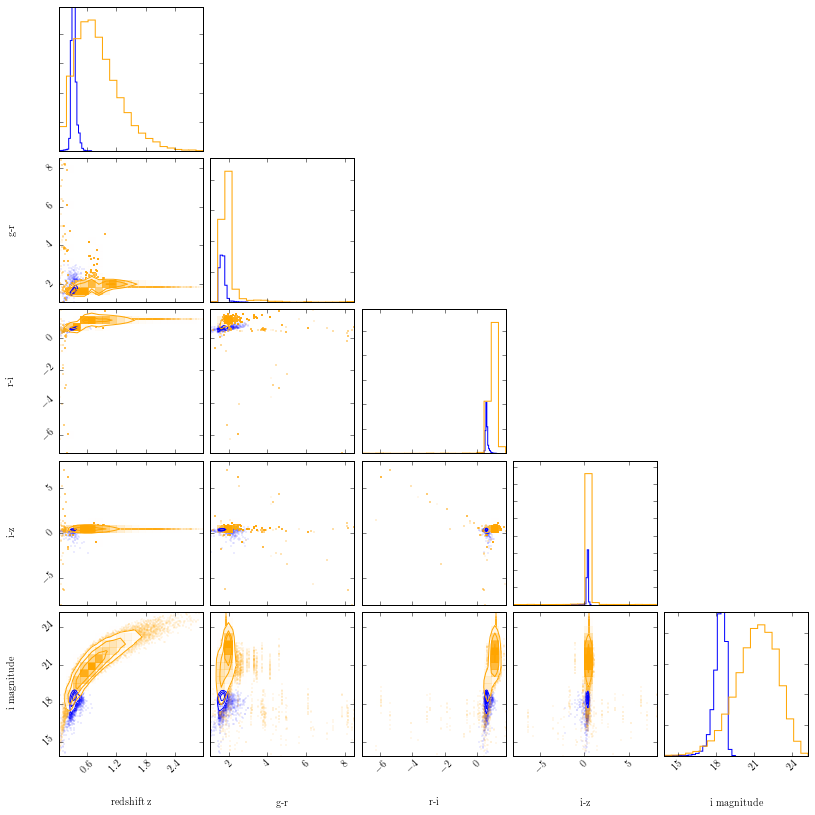

In [11]:
gr = data[:,4] - data[:,5]
ri = data[:,5] - data[:,6]
iz = data[:,6] - data[:,7]
i = data[:,6]
z = data[:,2]

# Clean out extreme colors in SDSS sample:
index = np.where((np.abs(gr)<3.0)*(np.abs(ri)<3.0)*(np.abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Make overlay from painted OM10 db:
overlay = np.array([db.sample['ZLENS'], \
                    db.sample['MAGG_LENS']-db.sample['MAGR_LENS'], \
                    db.sample['MAGR_LENS']-db.sample['MAGI_LENS'], \
                    db.sample['MAGI_LENS']-db.sample['MAGZ_LENS'], \
                    db.sample['MAGI_LENS']]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)

So, we have a problem: the SDSS LRG selection only returns very bright (i < 19) objects! This was why we went for CFHTLS initially. What we really need is a CFHTLS LRG catalog. 

#Testing color-based positioning code

In [1]:
%matplotlib inline
import om10,os
import numpy as np
import matplotlib.pyplot as plt
import triangle

In [2]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
db.paint()

In [3]:
db.get_sky_positions()

om10.DB: read in LRG sky position data from  /Users/mbaumer/pybin/OM10/data/CFHTLS_LRGs.txt
Mean LRG RA,DEC,z =  34.3807307408 -7.09643979181 0.612498 21.63331883
Mean LRG i,(g-r) =  34.3807307408 -7.09643979181 0.612498 21.63331883
om10.DB: number of LRGs stored =  10000


In [5]:
idx_list = db.assign_sky_positions()

Working! Let's verify colors:

In [8]:
idx_list = np.array(idx_list).flatten() #list/array hijinks

(array([  2.25300000e+03,   8.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   1.36000000e+02,   2.71000000e+02,
          4.06000000e+02,   5.41000000e+02,   6.76000000e+02,
          8.11000000e+02,   9.46000000e+02,   1.08100000e+03,
          1.21600000e+03,   1.35100000e+03]),
 <a list of 10 Patch objects>)

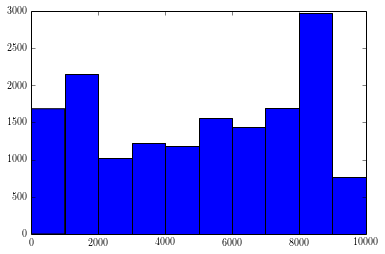

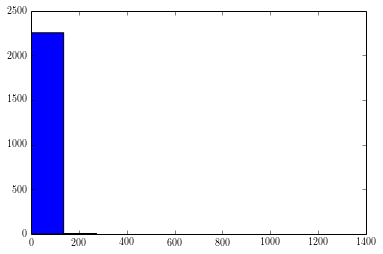

In [15]:
import scipy
from scipy.stats import itemfreq
_ = plt.hist(idx_list)
test = itemfreq(idx_list)
plt.figure()
plt.hist(test[:,1].flatten())

In [28]:
np.where([test == np.max(test[:,0])])

(array([0]), array([2265]), array([0]))

In [27]:
np.sort(test)

array([[  2.00000000e+00,   7.00000000e+00],
       [  2.00000000e+00,   6.00000000e+00],
       [  1.00000000e+00,   1.50000000e+01],
       ..., 
       [  1.00000000e+00,   9.97500000e+03],
       [  1.00000000e+00,   9.99700000e+03],
       [  2.00000000e+00,   9.99900000e+03]])

In [29]:
test[2265,:]

array([  9.99900000e+03,   2.00000000e+00])

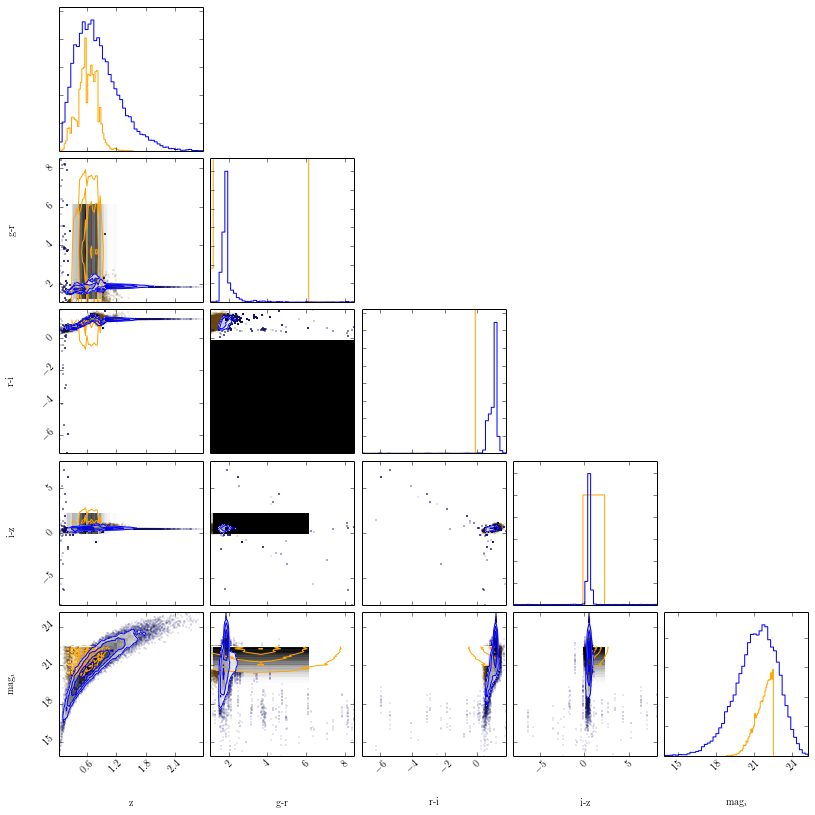

In [35]:
lens = db.sample

ref_features = np.array([db.LRGs['redshift'], db.LRGs['g-r'], db.LRGs['r-i'], \
                         db.LRGs['i-z'], db.LRGs['mag_i']]).transpose()

lens_features = np.array([lens['ZLENS'], lens['MAGG_LENS']-lens['MAGR_LENS'], \
            lens['MAGR_LENS']-lens['MAGI_LENS'], lens['MAGI_LENS']-lens['MAGZ_LENS'], lens['APMAG_I']]).transpose()

fig1 = triangle.corner(ref_features,labels=['z','g-r','r-i','i-z','mag_i'],color='Orange')
_ = triangle.corner(lens_features,fig=fig1,color='Blue')